In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
#ignoring warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Importing the dataset
df=pd.read_csv("../input/twitter-tweets-sentiment-dataset/Tweets.csv")

#  Data overview

In [4]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
df = df[['text', 'sentiment']]

In [6]:
df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


# Data Preprocessing

In [8]:
#checking for null values
df.isnull().sum()

text         1
sentiment    0
dtype: int64

In [9]:
# dropping null values
df.dropna(inplace=True)

In [10]:
df.isnull().sum()

text         0
sentiment    0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27480 non-null  object
dtypes: object(2)
memory usage: 644.1+ KB


In [12]:
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import string

In [13]:
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.update(['rt', 'mkr', 'didn', 'bc', 'n', 'm', 
                  'im', 'll', 'y', 've', 'u', 'ur', 'don', 
                  'p', 't', 's', 'aren', 'kp', 'o', 'kat', 
                  'de', 're', 'amp', 'will', 'wa', 'e', 'like'])
stemmer = SnowballStemmer('english')
def clean_text(text):
    
    # Remove Hashtag, Mention, URLs
    pattern = re.compile(r"(#[A-Za-z0-9]+|@[A-Za-z0-9]+|https?://\S+|www\.\S+|\S+\.[a-z]+|RT @)")
    text = pattern.sub('', text)
    text = " ".join(text.split())
    
    # Make all text lowercase
    text = text.lower()
    
    # Stemming
    text = " ".join([stemmer.stem(word) for word in text.split()])
    
    # Removing Punctuations
    remove_punc = re.compile(r"[%s]" % re.escape(string.punctuation))
    text = remove_punc.sub('', text)
    
    # Removing stopwords
    text = " ".join([word for word in str(text).split() if word not in STOPWORDS])
    
    return text

In [14]:
df['cleaned_text'] = df['text'].apply(lambda text: clean_text(text))  # Applying the cleaning to the text data

In [15]:
df.head()

,text,sentiment,cleaned_text
0,"I`d have responded, if I were going",neutral,id responded go
1,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad miss san diego
2,my boss is bullying me...,negative,boss bulli
3,what interview! leave me alone,negative,interview leav alon
4,"Sons of ****, why couldn`t they put them on t...",negative,son whi couldnt put releas alreadi bought


In [16]:
df['cleaned_text'].duplicated().sum() #checkimng for duplicate values

691

In [17]:
df.drop_duplicates("cleaned_text", inplace = True) #dropping duplicate values

In [18]:
df['cleaned_text'].str.isspace().sum()       # Checking for tweets with only whitespaces

0

In [19]:
df.isnull().sum()   # checking for null values

text            0
sentiment       0
cleaned_text    0
dtype: int64

In [20]:
df['sentiment'].value_counts()

neutral     10804
positive     8328
negative     7657
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

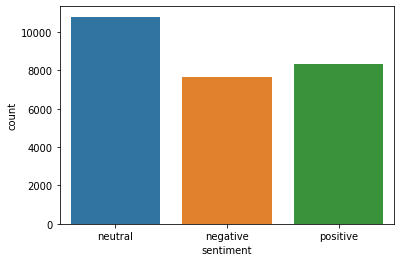

In [21]:
sns.countplot(data = df, x = 'sentiment')

In [22]:
# Plotting the top 15 words of each sentiment type
for sent in df.sentiment.unique():
    
    top15_word = df.cleaned_text[df.sentiment==sent].str.split(expand=True).stack().value_counts()[:15]
    
    fig = px.bar(top15_word, color=top15_word.values, color_continuous_scale=px.colors.sequential.RdPu, custom_data=[top15_word.values])
    fig.update_traces(marker_color='red')
    fig.update_traces(hovertemplate='<b>Count: </b>%{customdata[0]}')
    fig.update_layout(title=f"Top 15 words for {sent}",
                     template='simple_white',
                     hovermode='x unified')
    fig.show()

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [24]:
X = df['cleaned_text']  #Feature
y = df['sentiment']     #Target Label

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
# Performing the train|test split. This test set is essentially a hold out test set as we'll be performing Cross Validation
# using Grid Search which will split our training data into a training and validation split

In [26]:
tfidf = TfidfVectorizer(max_features = 5000)
# Using the TF - IDF Vectorizer to extract top 5000 most important features
# from the text data 

In [27]:
X_train_tfidf = tfidf.fit_transform(X_train)  # Creating the vocabulary only from the training set to avoid data leakage from 
X_test_tfidf = tfidf.transform(X_test)        # the test set.

In [28]:
X_train_tfidf   # Sparse Matrix is created to save memory since many values are close to 0

<21431x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 129184 stored elements in Compressed Sparse Row format>

In [29]:
X_test_tfidf   # Sparse Matrix

<5358x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 31989 stored elements in Compressed Sparse Row format>

# Model Training

In [30]:
from sklearn.metrics import plot_confusion_matrix, classification_report

              precision    recall  f1-score   support

    negative       0.71      0.57      0.63      1503
     neutral       0.62      0.75      0.68      2193
    positive       0.76      0.68      0.72      1662

    accuracy                           0.68      5358
   macro avg       0.70      0.67      0.68      5358
weighted avg       0.69      0.68      0.68      5358



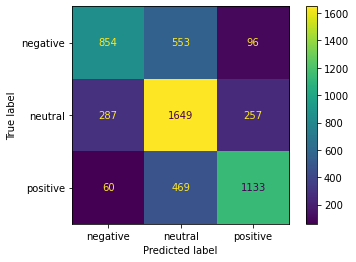

In [31]:
# LOGISTIC REGRESSION with the complete data
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
log_model = LogisticRegression(solver = 'saga',multi_class="ovr")
param_grid = {'C': np.logspace(0, 10, 5)}
grid_log_model = HalvingGridSearchCV(log_model, param_grid = param_grid, n_jobs = -1, min_resources = 'exhaust', factor = 3)
grid_log_model.fit(X_train_tfidf, y_train)
preds_grid_log_model = grid_log_model.predict(X_test_tfidf)
print(classification_report(y_test, preds_grid_log_model))
plot_confusion_matrix(grid_log_model, X_test_tfidf, y_test)

In [32]:
grid_log_model.best_estimator_

LogisticRegression(multi_class='ovr', solver='saga')

              precision    recall  f1-score   support

    negative       0.71      0.56      0.63      1503
     neutral       0.61      0.76      0.68      2193
    positive       0.77      0.68      0.72      1662

    accuracy                           0.68      5358
   macro avg       0.70      0.67      0.68      5358
weighted avg       0.69      0.68      0.68      5358



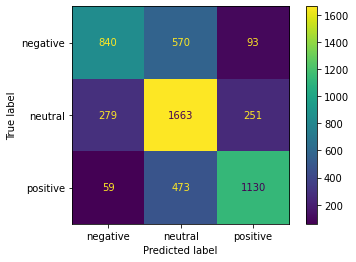

In [33]:
# Linear SVM Model
from sklearn.svm import LinearSVC
svm_model = LinearSVC()
C = [1e-5, 1e-4, 1e-2, 1e-1, 1]
param_grid = {'C': C}
grid_svm_model = HalvingGridSearchCV(svm_model, param_grid = param_grid, n_jobs = -1, min_resources = 'exhaust', factor = 3)
grid_svm_model.fit(X_train_tfidf, y_train)
preds_grid_svm_model = grid_svm_model.predict(X_test_tfidf)
print(classification_report(y_test, preds_grid_svm_model))
plot_confusion_matrix(grid_svm_model, X_test_tfidf, y_test)

              precision    recall  f1-score   support

    negative       0.72      0.57      0.64      1503
     neutral       0.62      0.77      0.69      2193
    positive       0.78      0.68      0.72      1662

    accuracy                           0.69      5358
   macro avg       0.70      0.67      0.68      5358
weighted avg       0.70      0.69      0.68      5358



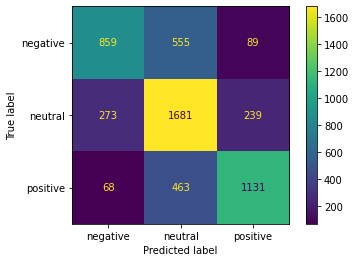

In [34]:
#SVM MODEL FOR HIGHER DIMENSIONS
from sklearn.svm import SVC
svm_model = SVC()
C = [1e-5, 1e-4, 1e-2, 1e-1, 1]
kernel = ['rbf', 'poly', 'sigmoid']
param_grid = {'C': C, 'kernel': kernel}
grid_svm_model = HalvingGridSearchCV(svm_model, param_grid = param_grid, n_jobs = -1, min_resources = 'exhaust', factor = 3)
grid_svm_model.fit(X_train_tfidf, y_train)
preds_grid_svm_model = grid_svm_model.predict(X_test_tfidf)
print(classification_report(y_test, preds_grid_svm_model))
plot_confusion_matrix(grid_svm_model, X_test_tfidf, y_test)

In [35]:
grid_svm_model.best_estimator_

SVC(C=1, kernel='sigmoid')

              precision    recall  f1-score   support

    negative       0.72      0.61      0.66      1503
     neutral       0.65      0.71      0.68      2193
    positive       0.73      0.75      0.74      1662

    accuracy                           0.69      5358
   macro avg       0.70      0.69      0.69      5358
weighted avg       0.70      0.69      0.69      5358



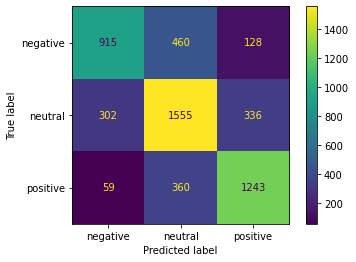

In [36]:
# Randon Forest
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state = 42)
n_estimators = [64, 100, 128]
bootstrap = [True, False] # Bootstrapping is true by default
param_grid = {'n_estimators': n_estimators, 'bootstrap': bootstrap}
grid_rf_model = HalvingGridSearchCV(rf_model, param_grid = param_grid, n_jobs = -1, min_resources = 'exhaust', factor = 3)
grid_rf_model.fit(X_train_tfidf, y_train)
preds_grid_rf_model = grid_rf_model.predict(X_test_tfidf)
print(classification_report(y_test, preds_grid_rf_model))
plot_confusion_matrix(grid_rf_model, X_test_tfidf, y_test)

In [37]:
grid_rf_model.best_estimator_

RandomForestClassifier(n_estimators=128, random_state=42)

              precision    recall  f1-score   support

    negative       0.77      0.46      0.58      1503
     neutral       0.59      0.81      0.68      2193
    positive       0.77      0.66      0.71      1662

    accuracy                           0.66      5358
   macro avg       0.71      0.64      0.65      5358
weighted avg       0.69      0.66      0.66      5358



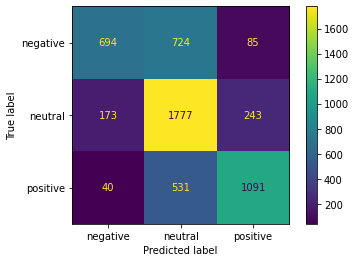

In [38]:
# GRADIENT BOOSTING
from sklearn.ensemble import GradientBoostingClassifier
grad_model = GradientBoostingClassifier(random_state = 42)
param_grid = {'n_estimators': [64, 100, 128, 200]}
grid_grad_model = HalvingGridSearchCV(grad_model, param_grid = param_grid, n_jobs = -1, min_resources = 'exhaust', factor = 3)
grid_grad_model.fit(X_train_tfidf, y_train)
preds_grid_grad_model = grid_grad_model.predict(X_test_tfidf)
print(classification_report(y_test, preds_grid_grad_model))
plot_confusion_matrix(grid_grad_model, X_test_tfidf, y_test)

In [39]:
grid_grad_model.best_estimator_

GradientBoostingClassifier(n_estimators=200, random_state=42)

              precision    recall  f1-score   support

    negative       0.71      0.47      0.57      1503
     neutral       0.56      0.76      0.64      2193
    positive       0.71      0.59      0.64      1662

    accuracy                           0.63      5358
   macro avg       0.66      0.61      0.62      5358
weighted avg       0.65      0.63      0.62      5358



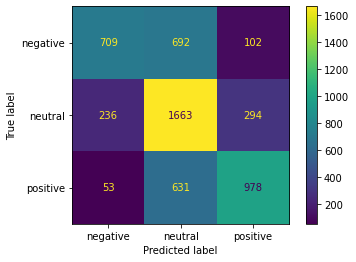

In [40]:
# NAIVE - BAYES
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
preds_nb_model = nb_model.predict(X_test_tfidf)
print(classification_report(y_test, preds_nb_model))
plot_confusion_matrix(nb_model, X_test_tfidf, y_test)

Random forest is performing better than other classifiers.

# Creating pipeline

In [41]:
# Creating a pipeline
from sklearn.pipeline import Pipeline
pipe = Pipeline([('tfidf', TfidfVectorizer(max_features = 5000)), ('rf_model', RandomForestClassifier(n_estimators = 128, random_state = 42))])
pipe.fit(X, y)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('rf_model',
                 RandomForestClassifier(n_estimators=128, random_state=42))])

# Taking tweets from internet and predicting their sentiments

In [42]:
pipe.predict(["The hard truth about the United States is that the money other countries spend on health and infrastructure, we spend on war."])

array(['negative'], dtype=object)

In [43]:
pipe.predict(["No one is born hating another person because of the color of his skin or his background or his religion"])

array(['neutral'], dtype=object)

In [44]:
pipe.predict(["White House weighs bold plan to privatize much of war in Afghanistan, Blackwater founder tells USA TODAY https://usat.ly/2wErDDt"])

array(['negative'], dtype=object)

In [45]:
pipe.predict(["Journey!? Wow... u just became cooler. hehe...."])

array(['positive'], dtype=object)